In [2]:
# !pip install numpy-2.3.1
!pip install gensim
!pip install pyLDAvis
!pip install wordcloud
# !pip install -U pip setuptools wheel
# !pip install -U spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 130.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompati

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 43.1 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np

import re
import string
from os import path
from PIL import Image

import os
os.path

#Gensim
import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# spacy for lemmatization
import spacy

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


/usr/local/lib/python3.11/dist-packages/spacy/cli/_util.py:23: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
/usr/local/lib/python3.11/dist-packages/weasel/util/config.py:8: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string


In [4]:
# Import Dataset txt file - 305 research papers
file_path = "/content/data_for_lda.xlsx"
data = pd.read_excel(file_path)

In [5]:
data.head()

,Title,Abstract,Author Keywords,Index Keywords
0,Examining the relationship between blockchain ...,Blockchain has enormous capabilities to transf...,Blockchain capabilities; Competitive advantage...,NaN
1,Blockchain-Based KYC Model for Credit Allocati...,The implementation of the Know Your Customer (...,blockchain; distributed ledger; Ethereum; Know...,Blockchain; Distributed computer systems; Dist...
2,Central Bank Digital Currencies: Financial Sta...,"Digitalization of the global economy, catalyse...",CBDCs; central bank; central bank digital curr...,NaN
3,Unveiling current and future trends in custome...,Purpose: This research is the first to use bib...,Bibliographic coupling; Bibliometric analysis;...,NaN
4,A quantitative analysis study of FinTech on ba...,Fintech has not only greatly improved the oper...,Fintech; Monte Carlo simulation; Operational e...,NaN


In [6]:
# prompt: can I concat the data from each row and put them in a new column as "text"?

data['text'] = data.apply(lambda row: ' '.join(row.astype(str)), axis=1)
data.head()

,Title,Abstract,Author Keywords,Index Keywords,text
0,Examining the relationship between blockchain ...,Blockchain has enormous capabilities to transf...,Blockchain capabilities; Competitive advantage...,NaN,Examining the relationship between blockchain ...
1,Blockchain-Based KYC Model for Credit Allocati...,The implementation of the Know Your Customer (...,blockchain; distributed ledger; Ethereum; Know...,Blockchain; Distributed computer systems; Dist...,Blockchain-Based KYC Model for Credit Allocati...
2,Central Bank Digital Currencies: Financial Sta...,"Digitalization of the global economy, catalyse...",CBDCs; central bank; central bank digital curr...,NaN,Central Bank Digital Currencies: Financial Sta...
3,Unveiling current and future trends in custome...,Purpose: This research is the first to use bib...,Bibliographic coupling; Bibliometric analysis;...,NaN,Unveiling current and future trends in custome...
4,A quantitative analysis study of FinTech on ba...,Fintech has not only greatly improved the oper...,Fintech; Monte Carlo simulation; Operational e...,NaN,A quantitative analysis study of FinTech on ba...


In [7]:
data_text = data[['text']]
data_text['index'] = data_text.index
documents = data_text


/tmp/ipython-input-7-2814378279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_text['index'] = data_text.index


In [8]:
print(len(documents))
print(documents[:5])

214
                                                text  index
0  Examining the relationship between blockchain ...      0
1  Blockchain-Based KYC Model for Credit Allocati...      1
2  Central Bank Digital Currencies: Financial Sta...      2
3  Unveiling current and future trends in custome...      3
4  A quantitative analysis study of FinTech on ba...      4


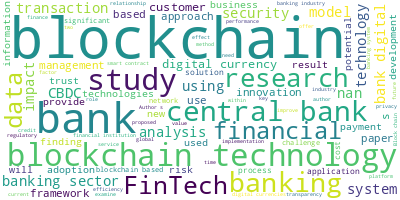

In [9]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(documents['text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=50000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [11]:
# NLTK Stop words
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the text
documents['text']=documents['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/tmp/ipython-input-11-1904734973.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents['text']=documents['text'].apply(remove_stopwords)


In [12]:
#Tokenize words and Clean-up text

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'et', 'al', 'doi', 'abstract', 'clinical', 'ml', 'cid', 'data', 'using', 'http','machine learning', 'used', 'ieee','receiv', 'infer', 'significant', 'patients', 'heart', 'cancer', 'none', 'model', 'university', 'research', 'editor', 'covid', 'ai', 'journal', 'features', 'learning', 'medical', 'informatio', 'treatment', 'health', 'consultant', 'care', 'risk', 'response', 'failure', 'learning', 'features','machine', 'mds', 'based', 'imaging', 'lime', 'hc', 'methods', 'university', 'tle', 'patients', 'mri', 'org', 'temporal', 'vol',
                   'network', 'pe', 'ct', 'alk', 'test', 'non', 'pet', 'two', 'set', 'inr', 'https', 'ac', 'vp', 'moto', 'ckd', 'cad', 'med', 'set', 'may', 'time', 'also', 'table', 'images', 'high', 'site', 'na', 'hf', 'sites', 'chr', 'follow', 'image', 'asd', 'ados', 'social', 'items', 'user', 'food', 'rule', 'mobile', 'https', 'application', 'applications', 'new', 'early', 'process', 'jmir', 'full', 'ncr', 'one', 'med', 'plos', 'pone', 'fig', 'ts', 'line', 'number', 'pmid', 'pp', 'note', 'oa', 'vector', 'set', 'de', 'pd', 'word', 'auc', 'copd','iv'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]
data = documents.text.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['examining', 'relationship', 'blockchain', 'capabilities', 'organizational', 'performance', 'indian', 'banking', 'sector', 'blockchain', 'enormous', 'capabilities', 'transform', 'traditional', 'business', 'models', 'countless', 'ways', 'banks', 'india', 'building', 'collaborative', 'blockchain', 'ecosystems', 'create', 'innovative', 'business', 'disrupt', 'traditional', 'create']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [14]:
from nltk.stem import PorterStemmer
stemmer=PorterStemmer()
stemmer.stem('numpang wifi stop gadget shopping')
'numpang wifi stop gadget shopping'

'numpang wifi stop gadget shopping'

In [15]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [18]:
doc = documents[documents['index'] == 213].values[0][0]
print('original document: ')
words = []
for word in doc.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc))

original document: 
['Blockchain', 'Won’t', 'Kill', 'Banks:', 'Why', 'Disintermediation', 'Doesn’t', 'Work', 'International', 'Trade', 'Finance', 'In', 'financial', 'services', 'industry,', 'many', 'people', 'assume', 'blockchain', 'significant', 'impacts.', 'From', 'research', 'practice,', 'observe', 'two', 'main', 'paradigms', 'organizations', 'interact', 'blockchain.', 'First,', 'organizations', 'use', 'blockchain', 'optimize', 'existing', 'processes', '(blockchain-based', 'business', 'process', 'optimization', '(BPO)).', 'Second,', 'organizations', 'use', 'blockchain', 'disrupt', 'existing', 'processes,', 'foster', 'disintermediation,', 'enable', 'disruptive', 'business', 'models', '(blockchain-based', 'business', 'process', 'disruption', '(BPD)).', 'However,', 'lack', 'scientific', 'research', 'evaluates', 'de', 'facto', 'potential.', 'We', 'bridge', 'gap', 'following', 'design', 'science', 'research', 'approach', 'design', 'blockchain-based', 'business', 'process', 're-engineerin

In [19]:
# Do lemmatization keeping only noun, adj, verb, adv
def lemmatization(texts,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
       output = []
       for sent in texts:
             doc = nlp(sent)
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [20]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 3), (8, 2), (9, 5), (10, 8), (11, 1), (12, 1), (13, 1), (14, 2), (15, 5), (16, 4), (17, 1), (18, 1), (19, 1), (20, 3), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1)]


In [21]:
processed_docs = documents['text'].map(preprocess)
processed_docs[:50]

,text
0,"[examin, relationship, blockchain, capabl, org..."
1,"[blockchain, base, model, credit, alloc, bank,..."
2,"[central, bank, digit, currenc, financi, stabi..."
3,"[unveil, current, futur, trend, custom, bank, ..."
4,"[quantit, analysi, studi, fintech, bank, oper,..."
5,"[polici, endors, central, bank, digit, currenc..."
6,"[enhanc, bank, transact, secur, hybrid, access..."
7,"[enhanc, foreign, exchang, reserv, secur, cent..."
8,"[blockchain, support, onlin, bank, scheme, onl..."
9,"[shape, futur, board, commun, credit, risk, bl..."


In [22]:
#Create the Dictionary and Corpus needed for Topic Modeling

dictionary = corpora.Dictionary(data_words)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in data_words]

In [23]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=20, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [24]:
lda_model.print_topics()

[(0,
  '0.033*"banking" + 0.027*"blockchain" + 0.015*"study" + 0.011*"financial" + 0.011*"approach" + 0.009*"fintech" + 0.009*"banks" + 0.009*"technology" + 0.008*"sector" + 0.007*"fraud"'),
 (1,
  '0.025*"blockchain" + 0.022*"financial" + 0.016*"bank" + 0.011*"banking" + 0.008*"access" + 0.007*"technology" + 0.007*"system" + 0.007*"key" + 0.007*"privacy" + 0.007*"open"'),
 (2,
  '0.019*"credit" + 0.017*"blockchain" + 0.011*"framework" + 0.011*"credential" + 0.009*"authentication" + 0.009*"stuffing" + 0.008*"management" + 0.008*"transparent" + 0.008*"attacks" + 0.006*"smart"'),
 (3,
  '0.019*"study" + 0.018*"accounting" + 0.016*"nigeria" + 0.014*"banks" + 0.013*"dmbs" + 0.011*"constraints" + 0.011*"deposit" + 0.011*"financial" + 0.011*"digital" + 0.010*"cloud"'),
 (4,
  '0.026*"digital" + 0.025*"bank" + 0.018*"financial" + 0.016*"central" + 0.009*"banks" + 0.009*"technology" + 0.008*"analysis" + 0.008*"monetary" + 0.008*"banking" + 0.008*"currencies"'),
 (5,
  '0.030*"banking" + 0.013*

In [25]:
# Visualize the topics
#https://github.com/bmabey/pyLDAvis
#https://speakerdeck.com/bmabey/visualizing-topic-models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.105103 -0.007201       1        1  15.117448
10    -0.073697 -0.037659       2        1  10.600196
18    -0.102663  0.000989       3        1   8.791140
4     -0.069800  0.144152       4        1   8.776613
9     -0.097044  0.155999       5        1   8.295629
1     -0.056824 -0.069753       6        1   6.908826
15    -0.069801 -0.118043       7        1   5.873067
19    -0.070638  0.066803       8        1   5.830606
0     -0.087901 -0.038433       9        1   5.806643
7     -0.050960 -0.076026      10        1   4.873041
5     -0.021722  0.012330      11        1   3.760174
8      0.006784 -0.105258      12        1   3.662367
16     0.006965 -0.061878      13        1   3.119387
13     0.029812  0.041478      14        1   2.595413
14     0.064366  0.087750      15        1   1.534221
3      0.095167  0.075295      16        1   1.293206
17     0.082805 -0.030617      17        1   1.273468
2      0.118823 -0.040449      18        1   0.985507
11     0.161087 -0.020333      19        1   0.518879
6      0.240345  0.020856      20        1   0.384169, topic_info=                 Term        Freq       Total Category  logprob  loglift
409              cbdc  137.000000  137.000000  Default  30.0000  30.0000
217           central  207.000000  207.000000  Default  29.0000  29.0000
10         blockchain  820.000000  820.000000  Default  28.0000  28.0000
28            digital  377.000000  377.000000  Default  27.0000  27.0000
116            credit   67.000000   67.000000  Default  26.0000  26.0000
...               ...         ...         ...      ...      ...      ...
2440         elements    0.366954    6.401068  Topic20  -5.7958   2.7029
763     investigating    0.366950    6.459392  Topic20  -5.7959   2.6938
1978  characteristics    0.634687   11.240550  Topic20  -5.2479   2.6877
2278        education    0.366936    8.342434  Topic20  -5.7959   2.4379
476           control    0.759380   29.190492  Topic20  -5.0686   1.9127

[1351 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4411      3  0.760718       abu
1110      1  0.211787  academic
1110      2  0.052947  academic
1110      3  0.211787  academic
1110      5  0.264734  academic
...     ...       ...       ...
2741      7  0.923652  workflow
2270     12  0.821325  workload
3209     11  0.618397       wos
2030      3  0.760718    yellow
3687     16  0.896595     yemen

[3310 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 11, 19, 5, 10, 2, 16, 20, 1, 8, 6, 9, 17, 14, 15, 4, 18, 3, 12, 7])

In [26]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=305))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.28864544189294

Coherence Score:  0.33667478698675


In [27]:

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=data_words, start=2, limit=50, step=1)

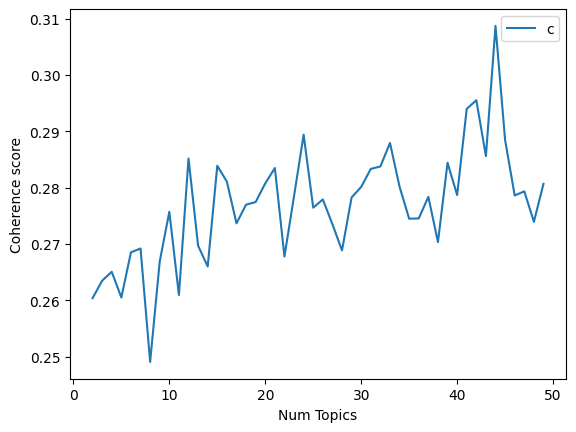

In [29]:

# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [30]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2604
Num Topics = 3  has Coherence Value of 0.2635
Num Topics = 4  has Coherence Value of 0.2651
Num Topics = 5  has Coherence Value of 0.2605
Num Topics = 6  has Coherence Value of 0.2685
Num Topics = 7  has Coherence Value of 0.2692
Num Topics = 8  has Coherence Value of 0.2491
Num Topics = 9  has Coherence Value of 0.2669
Num Topics = 10  has Coherence Value of 0.2757
Num Topics = 11  has Coherence Value of 0.2609
Num Topics = 12  has Coherence Value of 0.2852
Num Topics = 13  has Coherence Value of 0.2697
Num Topics = 14  has Coherence Value of 0.266
Num Topics = 15  has Coherence Value of 0.2839
Num Topics = 16  has Coherence Value of 0.2811
Num Topics = 17  has Coherence Value of 0.2737
Num Topics = 18  has Coherence Value of 0.277
Num Topics = 19  has Coherence Value of 0.2774
Num Topics = 20  has Coherence Value of 0.2808
Num Topics = 21  has Coherence Value of 0.2835
Num Topics = 22  has Coherence Value of 0.2678
Num Topics = 23  has Co

In [31]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=20)

[(0,
  '0.024*"blockchain" + 0.014*"banking" + 0.013*"digital" + 0.013*"technology" + 0.011*"financial" + 0.010*"bank" + 0.009*"central" + 0.007*"banks" + 0.007*"cbdc" + 0.007*"study" + 0.006*"payment" + 0.006*"system" + 0.005*"currency" + 0.005*"transactions" + 0.005*"security" + 0.004*"analysis" + 0.004*"sector" + 0.004*"nan" + 0.004*"transaction" + 0.004*"business"'),
 (1,
  '0.016*"blockchain" + 0.015*"banking" + 0.009*"banks" + 0.008*"customer" + 0.007*"financial" + 0.007*"technology" + 0.007*"analysis" + 0.007*"bank" + 0.006*"digital" + 0.006*"system" + 0.006*"study" + 0.005*"security" + 0.005*"central" + 0.004*"fintech" + 0.003*"nan" + 0.003*"transactions" + 0.003*"approach" + 0.003*"systems" + 0.003*"information" + 0.003*"adoption"'),
 (2,
  '0.024*"blockchain" + 0.015*"bank" + 0.011*"banking" + 0.011*"technology" + 0.011*"digital" + 0.009*"financial" + 0.009*"central" + 0.009*"banks" + 0.007*"cbdc" + 0.006*"analysis" + 0.005*"systems" + 0.005*"system" + 0.005*"study" + 0.005*"

In [32]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.017995 -0.027461       1        1  23.892563
4     -0.001613 -0.025269       2        1  21.201304
3      0.031444 -0.007226       3        1  17.196495
8      0.025226  0.007181       4        1  11.779965
2      0.007870  0.023470       5        1  10.332784
0      0.002029  0.009187       6        1   8.113162
5     -0.042954 -0.016827       7        1   3.096401
7     -0.008759  0.032360       8        1   2.966036
1     -0.031239  0.004584       9        1   1.421291, topic_info=           Term        Freq       Total Category  logprob  loglift
7       banking  617.000000  617.000000  Default  30.0000  30.0000
10   blockchain  844.000000  844.000000  Default  29.0000  29.0000
213        bank  347.000000  347.000000  Default  28.0000  28.0000
28      digital  376.000000  376.000000  Default  27.0000  27.0000
8         banks  311.000000  311.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
586    services    1.101994  100.602885   Topic9  -6.0044  -0.2605
161  management    1.095804  111.972175   Topic9  -6.0101  -0.3732
353       value    0.996245   58.718580   Topic9  -6.1053   0.1771
418    currency    1.028941  108.283283   Topic9  -6.0730  -0.4026
14     business    1.011399  116.072751   Topic9  -6.0902  -0.4893

[711 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2645      4  0.621781   academia
460       1  0.180553     access
460       2  0.257933     access
460       3  0.103173     access
460       4  0.077380     access
...     ...       ...        ...
2741      4  0.203028   workflow
2269      1  0.697054  workflows
1561      1  0.741104      worth
3209      1  0.585583        wos
3070      2  0.597168    xgboost

[1566 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 4, 9, 3, 1, 6, 8, 2])

In [34]:
#TFinding the dominant topic in each sentence

def format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix, texts=data_words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df, pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]).to_frame().T], ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

     # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=doc_term_matrix, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# Show
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.5538,"blockchain, financial, bank, banking, technolo...","[examining, relationship, blockchain, capabili..."
1,1,8,0.7379,"blockchain, technology, digital, bank, banking...","[blockchain, kyc, credit, allocation, banking,..."
2,2,4,0.7583,"blockchain, banking, financial, digital, techn...","[central, bank, digital, currencies, financial..."
3,3,4,0.9944,"blockchain, banking, financial, digital, techn...","[unveiling, current, future, trends, customer,..."
4,4,7,0.9932,"digital, bank, banking, banks, blockchain, stu...","[quantitative, analysis, study, fintech, banks..."
5,5,6,0.6693,"banking, blockchain, technology, financial, di...","[policy, endorsement, central, bank, digital, ..."
6,6,4,0.9951,"blockchain, banking, financial, digital, techn...","[enhancing, banking, transaction, security, hy..."
7,7,2,0.9928,"blockchain, bank, banking, technology, digital...","[enhancing, foreign, exchange, reserve, securi..."
8,8,6,0.7334,"banking, blockchain, technology, financial, di...","[blockchain, supported, online, banking, schem..."
9,9,8,0.589,"blockchain, technology, digital, bank, banking...","[shaping, future, board, communication, credit..."


In [35]:
#Find the most representative document for each topic
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(20)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.9959,"blockchain, banking, digital, technology, financial, bank, central, banks, cbdc, study","[novel, central, bank, digital, currency, framework, design, offline, foreign, transactions, blo..."
1,1,0.8822,"blockchain, banking, banks, customer, financial, technology, analysis, bank, digital, system","[blockchain, eom, approach, reconciliation, banking, purpose, study, aim, evaluate, contribution..."
2,2,0.9961,"blockchain, bank, banking, technology, digital, financial, central, banks, cbdc, analysis","[blockchain, key, revocation, access, control, open, banking, open, banking, allows, banks, fina..."
3,3,0.9968,"blockchain, financial, bank, banking, technology, banks, study, fintech, digital, central","[impact, decentralized, finance, development, banks, deposits, variability, pvar, approach, purp..."
4,4,0.9957,"blockchain, banking, financial, digital, technology, banks, study, sector, fintech, customer","[blockchain, identity, management, access, control, framework, open, banking, ecosystem, financi..."
5,5,0.9961,"banking, blockchain, technology, financial, analysis, system, digital, security, study, banks","[enhancing, money, laundering, detection, bank, transactions, gagan, graph, adapted, generative,..."
6,6,0.9964,"banking, blockchain, technology, financial, digital, bank, study, banks, sector, fintech","[bank, financing, strategy, commerce, supply, chain, driven, blockchain, introduction, commerce,..."
7,7,0.9932,"digital, bank, banking, banks, blockchain, study, financial, cbdc, central, system","[quantitative, analysis, study, fintech, banks, operational, efficiency, management, monte, carl..."
8,8,0.9969,"blockchain, technology, digital, bank, banking, central, study, banks, financial, cbdc","[effect, blockchain, business, intelligence, efficiency, banks, purpose, accurate, evaluation, c..."


In [36]:
#Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 5)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
pd.set_option('display.max_rows', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,3,"blockchain, financial, bank, banking, technology, banks, study, fintech, digital, central",18.0,0.08411
1,8,"blockchain, technology, digital, bank, banking, central, study, banks, financial, cbdc",2.0,0.00935
2,4,"blockchain, banking, financial, digital, technology, banks, study, sector, fintech, customer",22.0,0.10280
3,4,"blockchain, banking, financial, digital, technology, banks, study, sector, fintech, customer",35.0,0.16355
4,7,"digital, bank, banking, banks, blockchain, study, financial, cbdc, central, system",46.0,0.21495
5,6,"banking, blockchain, technology, financial, digital, bank, study, banks, sector, fintech",7.0,0.03271
6,4,"blockchain, banking, financial, digital, technology, banks, study, sector, fintech, customer",50.0,0.23364
7,2,"blockchain, bank, banking, technology, digital, financial, central, banks, cbdc, analysis",7.0,0.03271
8,6,"banking, blockchain, technology, financial, digital, bank, study, banks, sector, fintech",27.0,0.12617
9,8,"blockchain, technology, digital, bank, banking, central, study, banks, financial, cbdc",NaN,NaN


In [37]:
pd.set_option('display.max_rows', None)

In [38]:
print(df_dominant_topics)

    Dominant_Topic  \
0                3   
1                8   
2                4   
3                4   
4                7   
5                6   
6                4   
7                2   
8                6   
9                8   
10               3   
11               0   
12               4   
13               4   
14               5   
15               4   
16               6   
17               3   
18               4   
19               6   
20               2   
21               4   
22               2   
23               3   
24               0   
25               0   
26               4   
27               4   
28               8   
29               6   
30               8   
31               3   
32               7   
33               2   
34               3   
35               3   
36               5   
37               2   
38               3   
39               2   
40               3   
41               4   
42               1   
43               2   
44        

In [39]:
df_dominant_topics.to_csv('LDA_topic_modeling.csv')

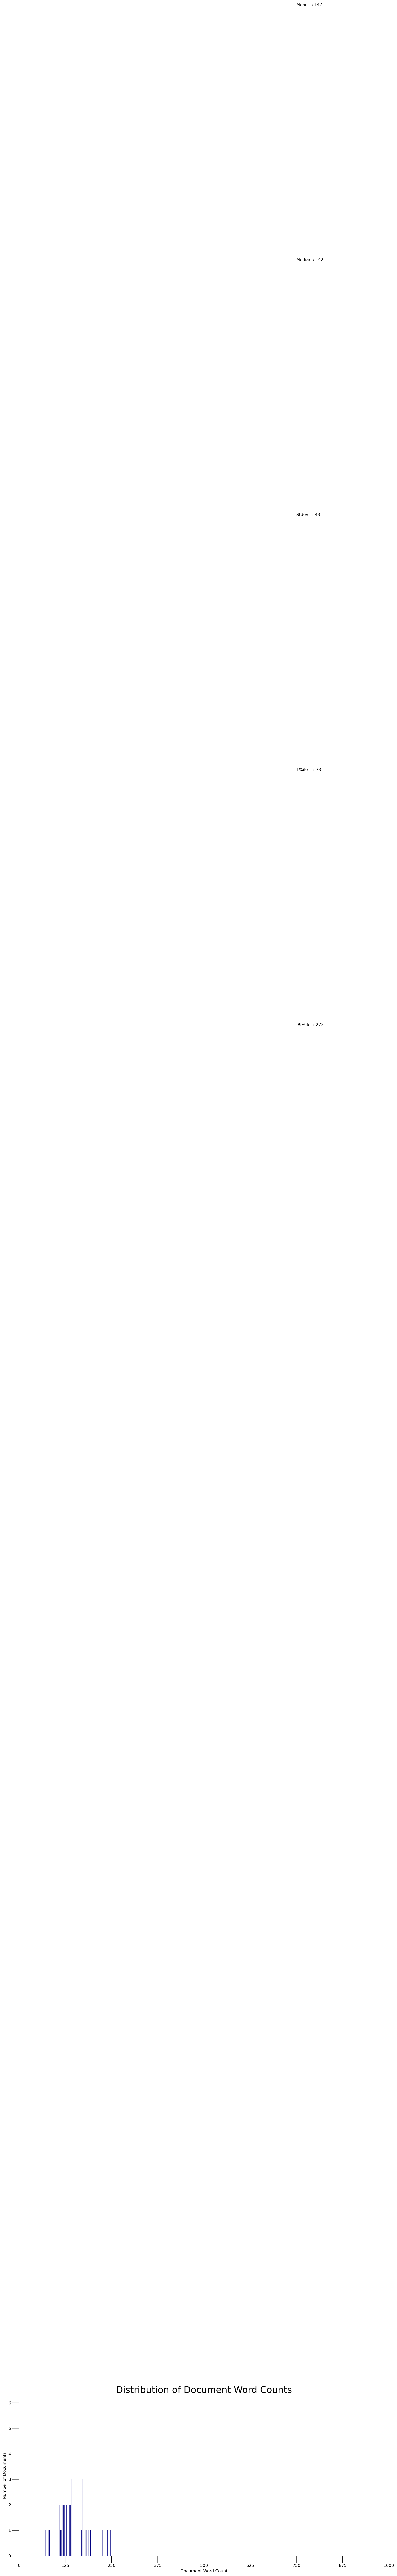

In [40]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

/tmp/ipython-input-41-2460086901.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
/tmp/ipython-input-41-2460086901.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
/tmp/ipython-input-41-2460086901.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
/tmp/ipython-input-41-2460086901.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdepl

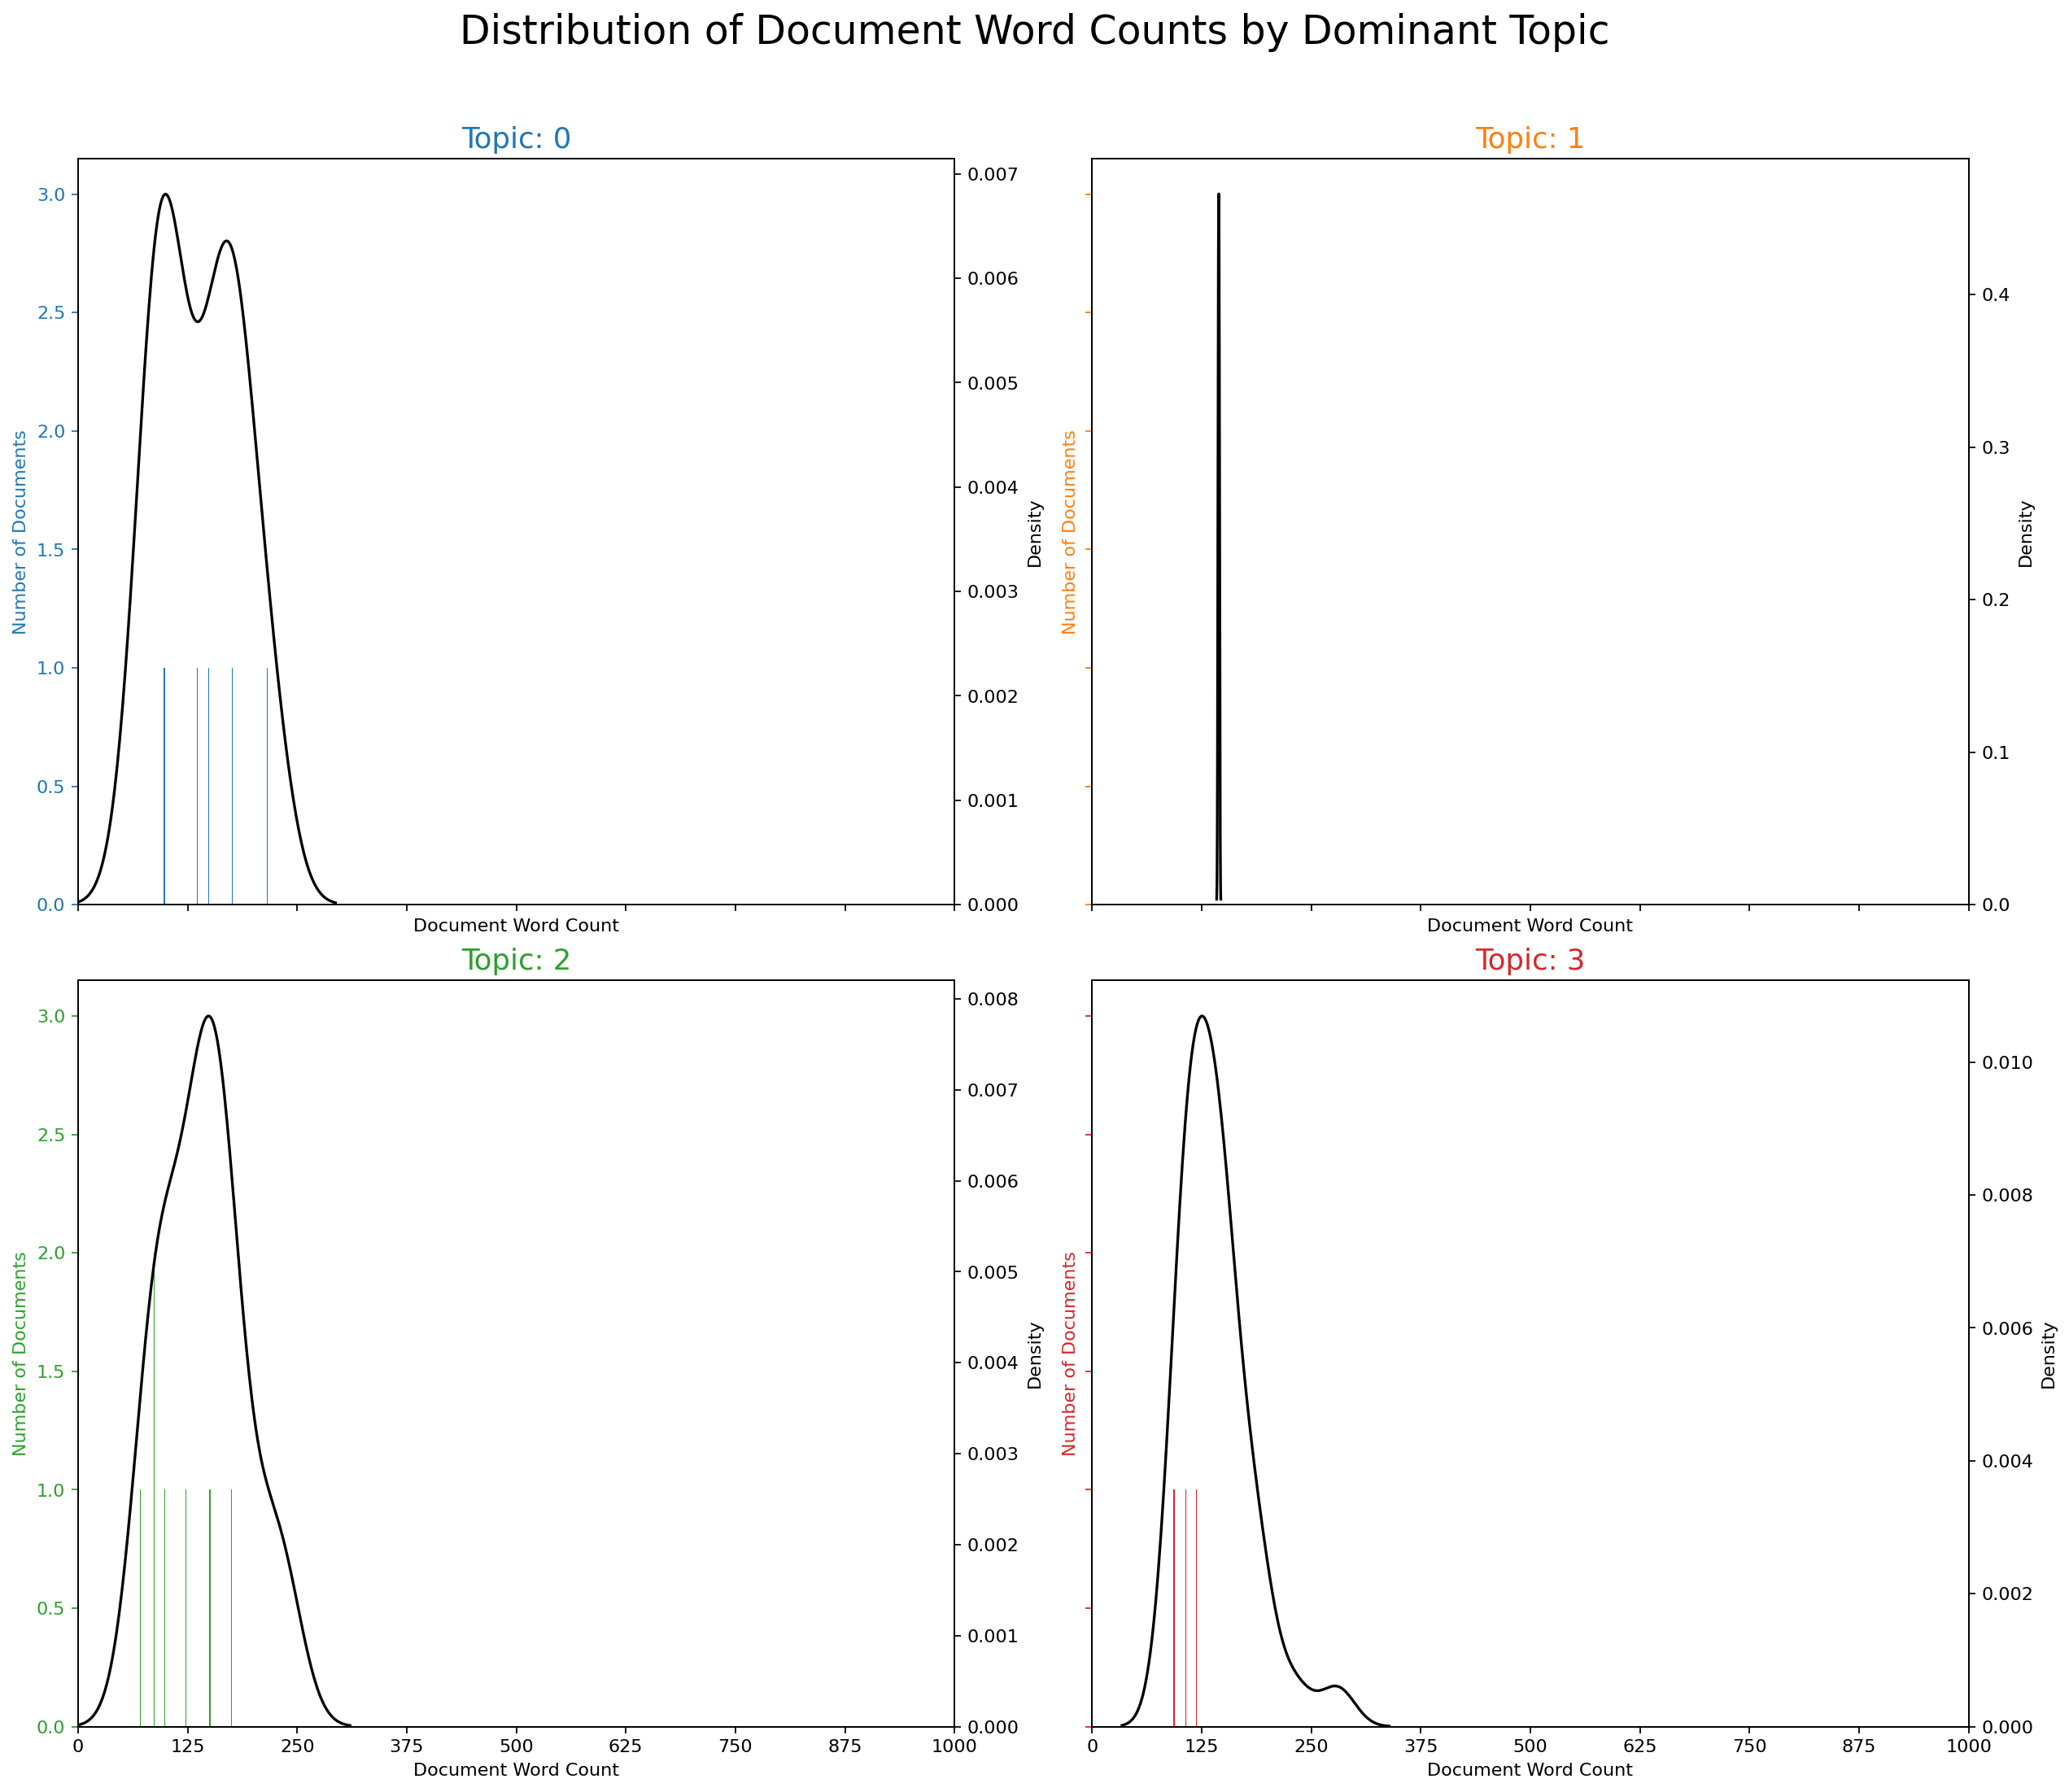

In [41]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

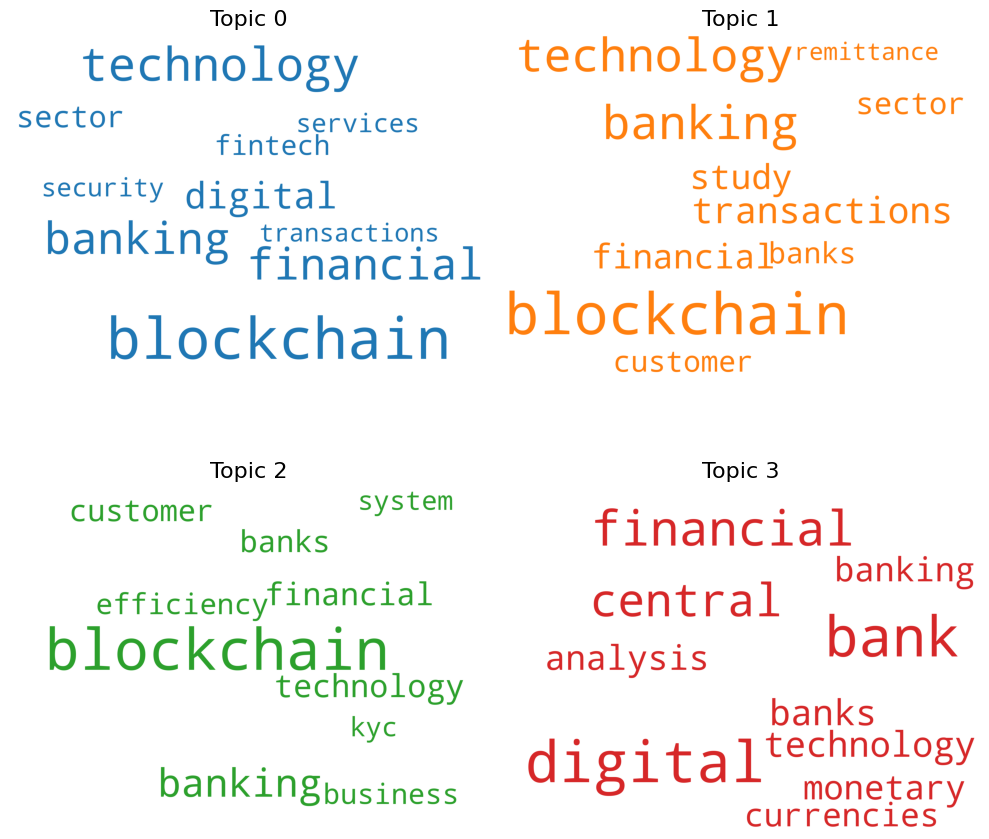

In [42]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

/tmp/ipython-input-43-2773411210.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipython-input-43-2773411210.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


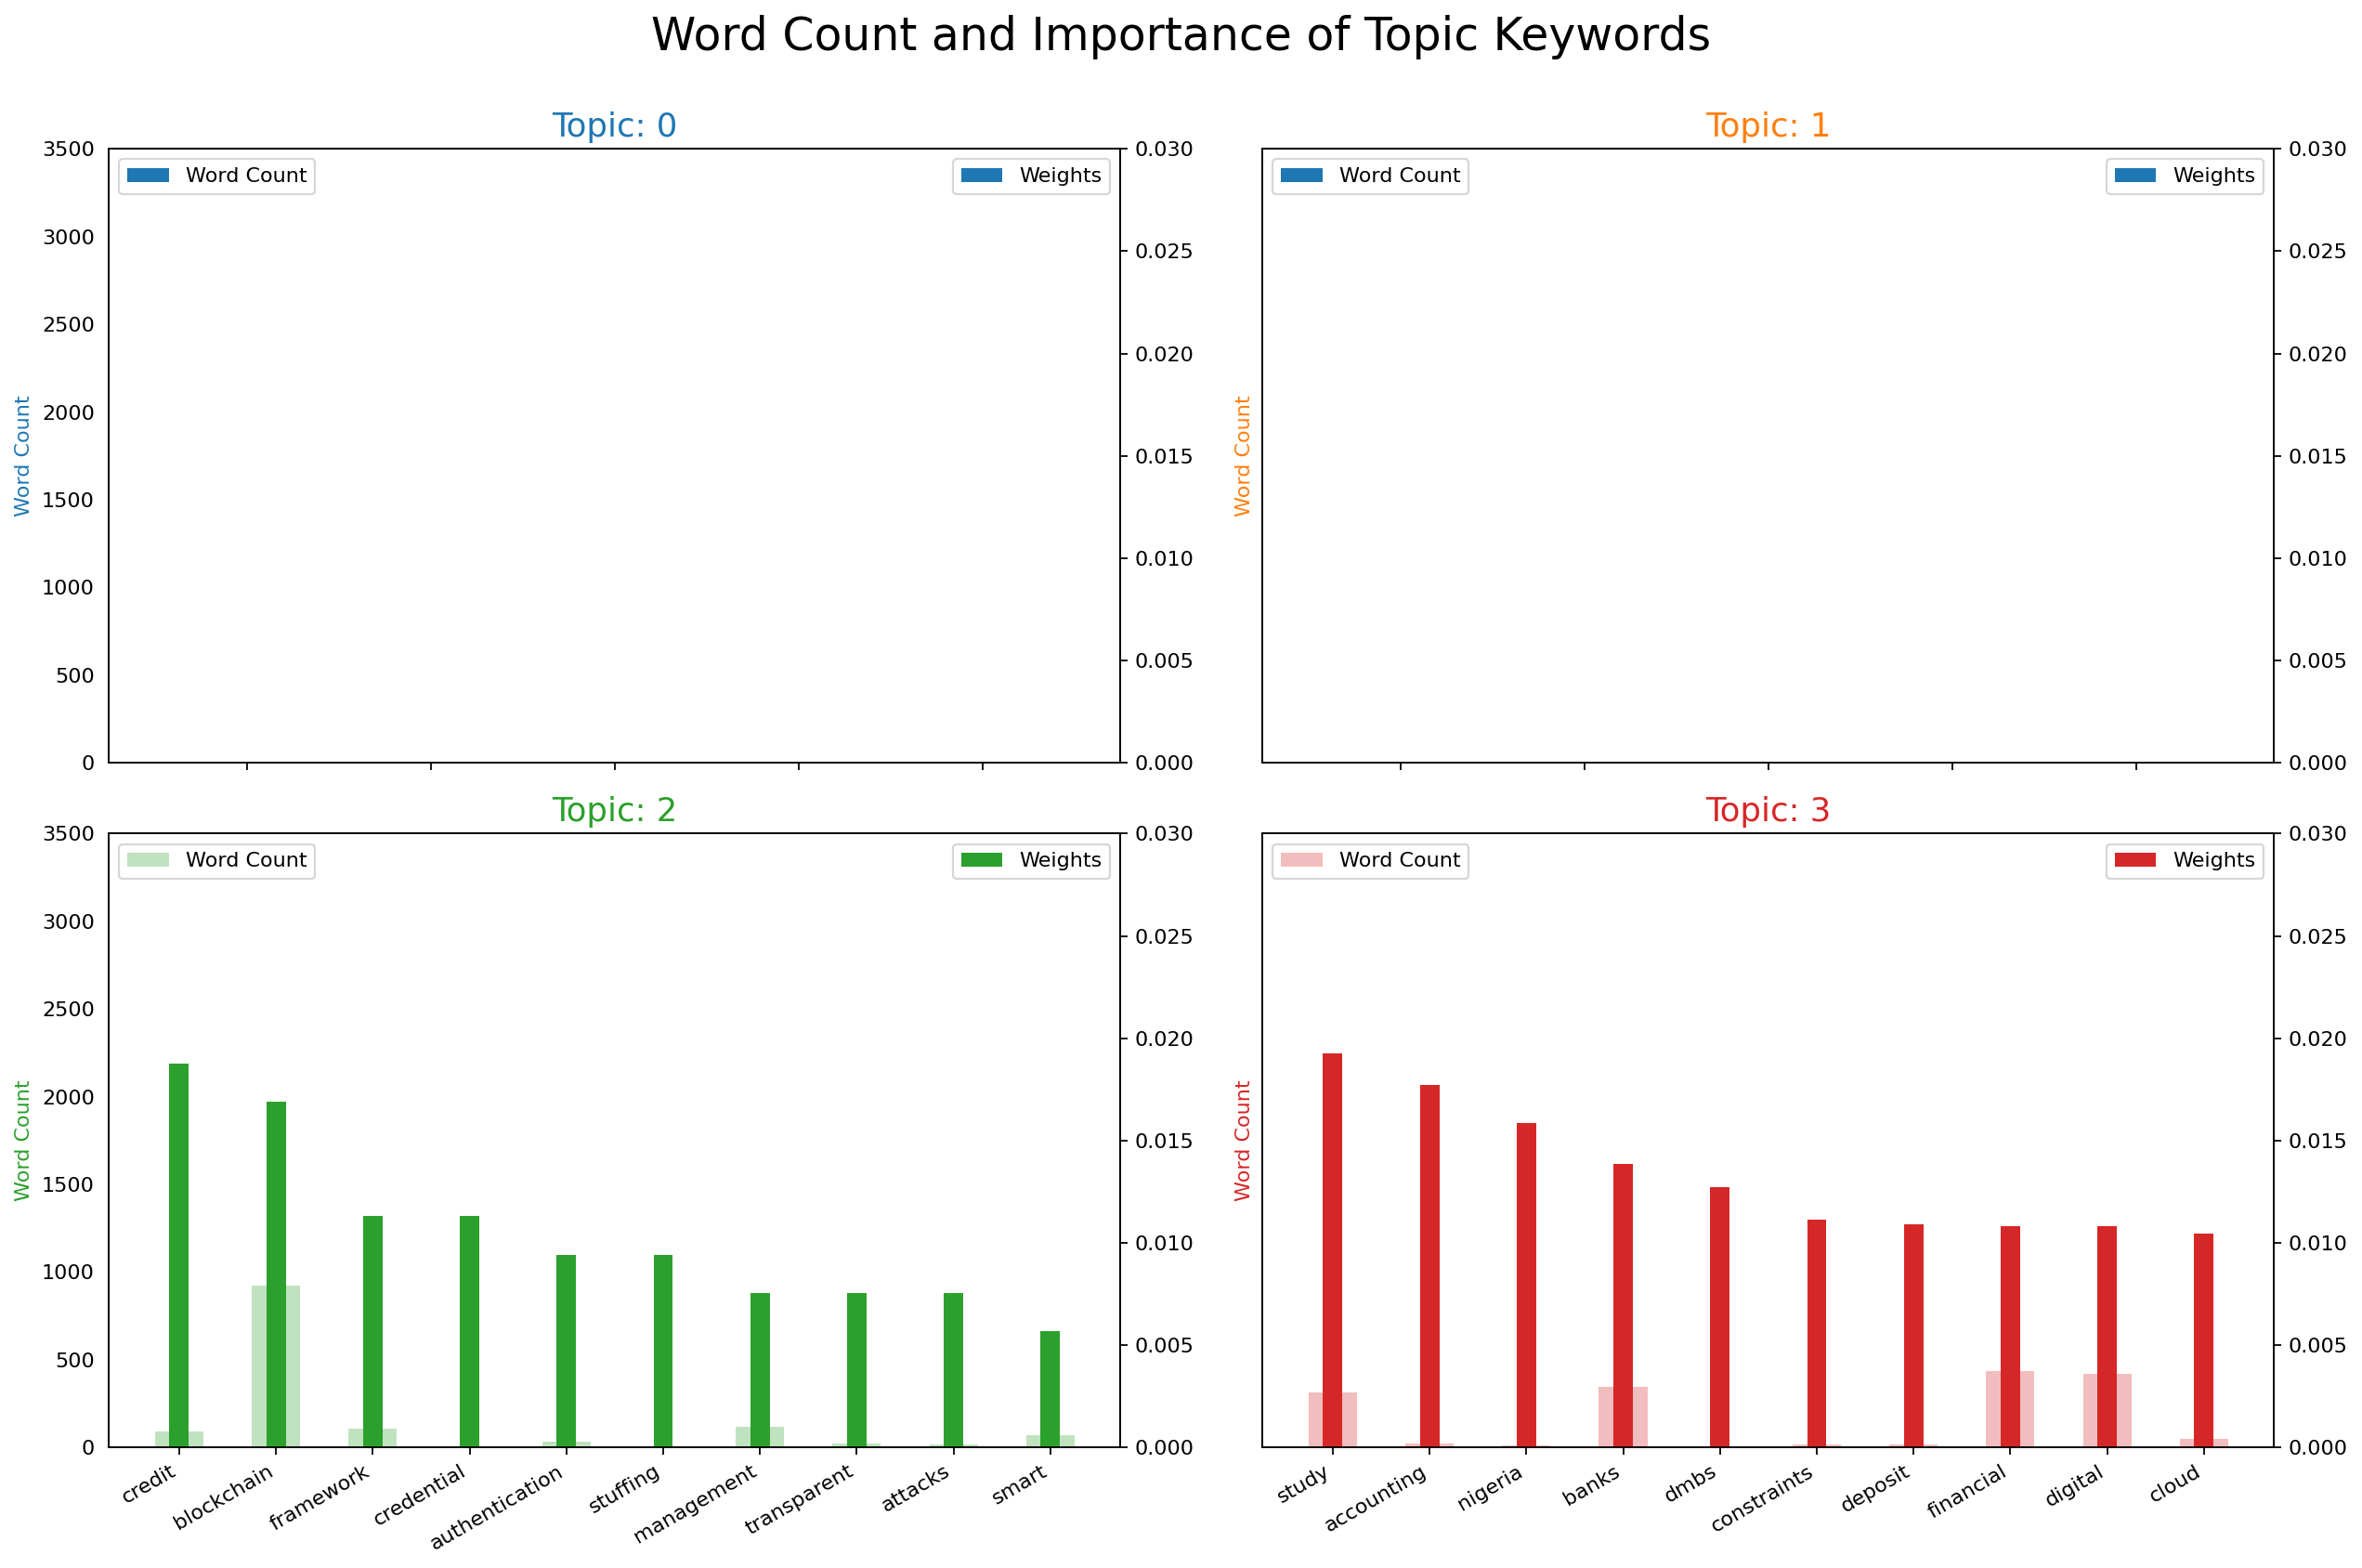

In [43]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()